In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import sklearn
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
import itertools

%matplotlib inline

In [ ]:
data_path = "/content/drive/MyDrive/Garbage classification"

In [ ]:
image_size=120
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Basic data augmentation
    transforms.ToTensor(),transforms.Resize((image_size,image_size)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

image_data = ImageFolder(root=data_path, transform=image_transforms)

In [ ]:
image_data.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [ ]:
image_data.extensions

('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

In [ ]:
train_ds, val_ds, test_ds = random_split(image_data, [1593, 176, 758]) 

In [ ]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(26, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


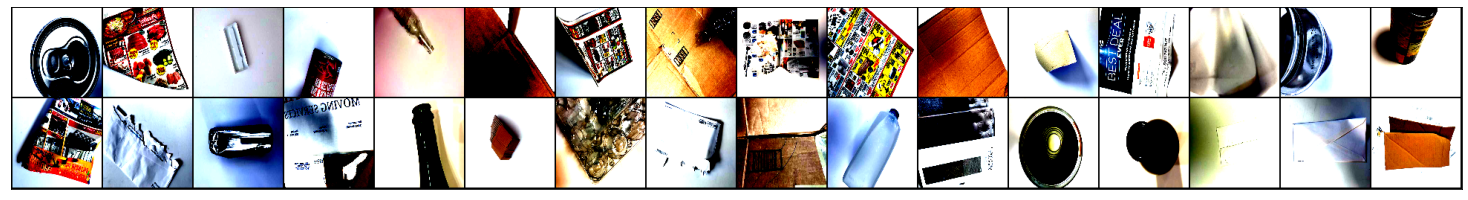

In [ ]:
show_batch(train_dl)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


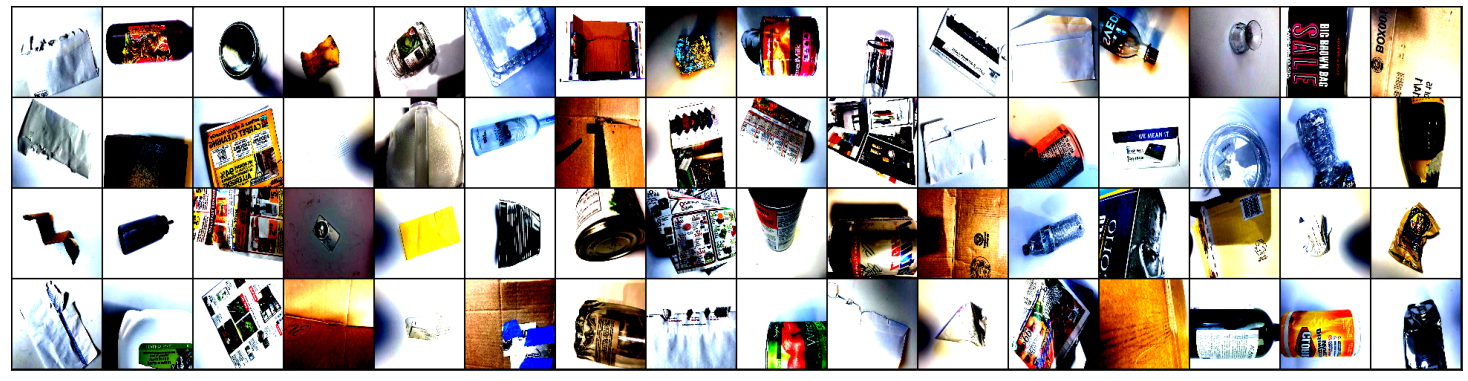

In [ ]:
show_batch(val_dl)

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, lr, epochs=10):
    
    batch_losses = []
    training_losses = []
    iters = []
    validation_losses = []
    validation_accuracies = []
    training_accuracies = []
    validation_loss=0.0
    validation_accuracy=0.0
    n = 0
    
    # Epochs loop...
    for epoch in range(epochs):
        training_loss = 0.0
        start = time.time()
        model.train() # Put model in 'training mode'
        
        # Train in batches
        for batch in train_loader:
            images, labels = batch
            optimizer.zero_grad() # Reset gradients
            output = model(images) # forward pass
            loss = loss_fn(output, labels) # Calculate loss
            
            loss.backward() # Calculate gradients
            #print(loss)
            optimizer.step() # Update weights

            training_loss += loss.data.item()
            batch_losses.append(loss.data.item())
                        
        # Model evaluation on full test set after all batches complete
        validation_loss, validation_accuracy, val_num_correct, val_num_examples = eval_model(model, loss_fn, val_loader)
        
        # Model evaluation on training set
        _, training_accuracy, train_num_correct, train_num_examples = eval_model(model, loss_fn, train_loader)
        
        # Calculate overall training and validation losses
        training_loss = training_loss / len(train_loader)
        
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)
        iters.append(n)
        n += 1

        end = time.time()
        print('Epoch: {}/{} Train Loss: {:.2f} Train Accuracy: {:.2f} Val loss: {:.2f} Val Accuracy: {:.2f} - {:.2f}secs'.format(
            epoch+1, epochs, training_loss, training_accuracy, validation_loss, validation_accuracy, end-start ))

    # Plot training curves
    plt.title("Training Loss per Batch (batch_size={} lr={})".format(batch_size,lr))
    batch_iters = range(len(batch_losses))
    plt.plot(batch_iters, batch_losses)
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    
    plt.title("Training Curve (batch_size={} lr={})".format(batch_size,lr))
    plt.plot(iters, training_losses, label="Train")
    plt.plot(iters, validation_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Training Curve (batch_size={} lr={})".format(batch_size,lr))
    plt.plot(iters, training_accuracies, label="Training Accuracy")
    plt.plot(iters, validation_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def eval_model(model, loss_fn, data_loader):
    # Model evaluation after all batches complete
    model.eval() # put model in 'eval' mode
    num_correct = 0
    num_examples = 0
    average_loss = 0.0

    with torch.no_grad(): # evaluating so no need to do any autograd
        for batch in data_loader:
            images, labels = batch
            predictions = model(images) # get predictions

            loss = loss_fn(predictions, labels)
            average_loss += loss.data.item()

            prediction_labels = torch.argmax(predictions, dim=1) # vector of index positions [2,0,1,2,2,1,2,0]
            correct = torch.eq(prediction_labels, labels) # Vector of T/F correct predictions [T,T,F]

            num_correct += torch.sum(correct).item() # Count of number correct in this batch - 2
            num_examples += labels.shape[0] # number of items in this batch

    average_loss = average_loss / len(data_loader)
    accuracy = num_correct / num_examples
    return average_loss, accuracy, num_correct, num_examples

In [ ]:
class FullyConnectedModel(nn.Module):
    def __init__(self, layer1_nodes=100, layer2_nodes=50, use_dropout=False):
        super(FullyConnectedModel, self).__init__()
        
        self.layer1_nodes = layer1_nodes
        self.layer2_nodes = layer2_nodes
        self.use_dropout = use_dropout
        
        
        self.fc1 = nn.Linear(image_size * image_size * 3, layer1_nodes) # 100 node hidden layer
        self.fc2 = nn.Linear(layer1_nodes, layer2_nodes) # 50 node hidden layer
        self.out = nn.Linear(layer2_nodes, 6) # 3 output channels for 2 x classification labels
        self.dropout = nn.Dropout()
        
    def forward(self, img):
        # Input Layer - flatten the image
        x = img.view(-1, image_size * image_size * 3) 
        
        # Hidden layer 1
        x = F.relu(self.fc1(x))
        
        if self.use_dropout:
            x = self.dropout(x)
        
        # Hidden later 2
        x = F.relu(self.fc2(x))
        
        if self.use_dropout:
            x = self.dropout(x)
        
        # Output layer - do not apply softmax here as we are using CrossEntropyLoss where softmax is implicit
        x = self.out(x)
        
        return x

# Show instance details
print(FullyConnectedModel())

FullyConnectedModel(
  (fc1): Linear(in_features=43200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for parm in model_conv.parameters():
  parm.requires_grad = False

num_fts = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_fts,6)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) #120-3+1 =118
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) #59-3+1 = 57
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) #28-3+1 = 26
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,6)
        
    def forward(self,x):
        x = self.conv1(x) #118*118*16
        x = self.relu(x)
        x = self.pool(x) #59*59*16
        x = self.conv2(x) #57*57*32
        x = self.relu(x)
        x = self.pool(x) # 28*28*32
        x = self.conv3(x) #26*26*48
        x = self.relu(x)
        x = self.pool(x) #13*13*48
        
        x = self.conv4(x) # 11*11*128
        x = self.relu(x)
        x = self.pool(x) # 5*5*128
        x = self.conv5(x) # 
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        
        return x

In [ ]:
# class Cnn(nn.Module):
#     def __init__(self):
#         super(Cnn,self).__init__()
        
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#             )
        
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        
        
#         self.fc1 = nn.Linear(3*3*64,10)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(10,6)
#         self.relu = nn.ReLU()
        
        
#     def forward(self,x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0),-1)
#         out = self.relu(self.fc1(out))
#         out = self.fc2(out)
#         return out

In [ ]:
#model = CNN()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Before Training: Validation loss: 2.20 Accuracy: 0.23 (41/176)
Epoch: 1/20 Train Loss: 1.38 Train Accuracy: 0.67 Val loss: 0.98 Val Accuracy: 0.66 - 144.71secs
Epoch: 2/20 Train Loss: 0.95 Train Accuracy: 0.74 Val loss: 0.84 Val Accuracy: 0.73 - 110.28secs
Epoch: 3/20 Train Loss: 0.78 Train Accuracy: 0.79 Val loss: 0.75 Val Accuracy: 0.74 - 112.12secs
Epoch: 4/20 Train Loss: 0.68 Train Accuracy: 0.80 Val loss: 0.72 Val Accuracy: 0.76 - 113.70secs
Epoch: 5/20 Train Loss: 0.65 Train Accuracy: 0.82 Val loss: 0.65 Val Accuracy: 0.80 - 112.35secs
Epoch: 6/20 Train Loss: 0.62 Train Accuracy: 0.83 Val loss: 0.65 Val Accuracy: 0.78 - 113.43secs
Epoch: 7/20 Train Loss: 0.56 Train Accuracy: 0.84 Val loss: 0.63 Val Accuracy: 0.79 - 113.57secs
Epoch: 8/20 Train Loss: 0.57 Train Accuracy: 0.80 Val loss: 0.75 Val Accuracy: 0.74 - 114.25secs
Epoch: 9/20 Train Loss: 0.53 Train Accuracy: 0.86 Val loss: 0.61 Val Accuracy: 0.80 - 115.56secs
Epoch: 10/20 Train Loss: 0.52 Train Accuracy: 0.87 Val loss: 0.6

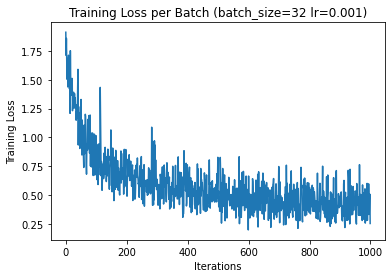

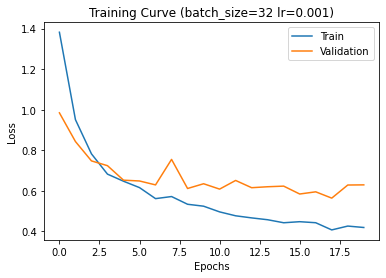

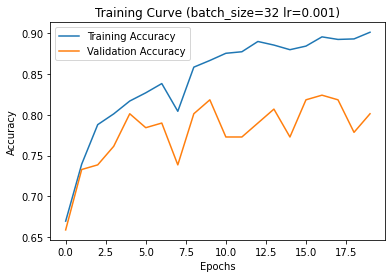

In [ ]:
LR=0.001  # Learning rate; 0.001
EPOCHS=20
model = model_conv
# Initialize model, optimizer and loss function
#model = FullyConnectedModel()
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

#Sanity check to ensure model cannot predict anything before training (circa 33% accuracy expected here)
validation_loss, accuracy, num_correct, num_examples = eval_model(model, loss_fn, val_dl)
print('Before Training: Validation loss: {:.2f} Accuracy: {:.2f} ({}/{})'.format(
            validation_loss, accuracy, num_correct, num_examples ))

train(model, optimizer, loss_fn, train_dl, val_dl, lr=LR, epochs=EPOCHS)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return image_data.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: trash , Predicted: paper


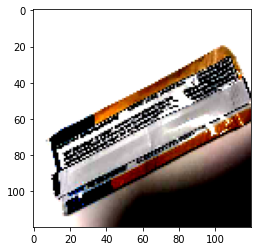

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', image_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cardboard , Predicted: cardboard


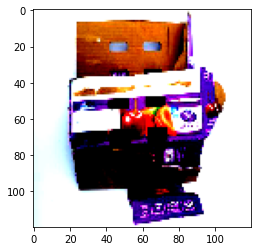

In [ ]:
img, label = test_ds[4]
plt.imshow(img.permute(1, 2, 0))
print('Label:', image_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: plastic , Predicted: plastic


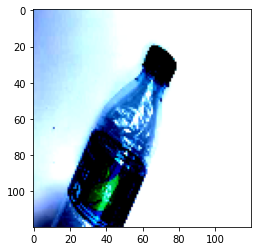

In [ ]:
img, label = test_ds[119]
plt.imshow(img.permute(1, 2, 0))
print('Label:', image_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: plastic , Predicted: plastic


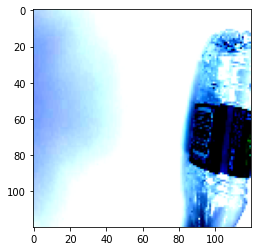

In [ ]:
img, label = test_ds[400]
plt.imshow(img.permute(1, 2, 0))
print('Label:', image_data.classes[label], ', Predicted:', predict_image(img, model))